In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from wrangle import epl_aq_all
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import regex as re

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Project Goals
1. Create a regression of point differential in predicting future points
2. Analyze the importance of draws in pythagorean expectations predictions
3. Predict by placement (classification) especially on relegation side??

# Wrangle Data
Three functions acquiring and prepping data are all available in wrangle.py file.
- 1. `epl_year_aq`: pulls in data frame from season
- 2. `strip_team_name`: takes in season csv and splits and cleans team_name_column 
- 3. `epl_aq_all`: creates df of all seasons of epl
- 4. `rename columns`: renamess columns explicitly
- 5. `make_number_of_seasons`: makes a column for number of seasons

In [ ]:
df = epl_aq_all()

In [ ]:
# def assessing_post_season(x):
#     if x <= 4:
#         return 'champions_league'
#     elif x <= 8:
#         return 'europa_league'
#     elif x <= 14:
#         return 'mid_table'
#     elif x <= 17:
#         return'relegation_battle'
#     else:
#         return 'relegation'

In [ ]:
# df.to_csv('epl_years.csv')
# df['finish'] = df.place.apply(assessing_post_season)
# df.head()

In [67]:
df = pd.read_csv('epl_years.csv')

In [68]:
df['next_year'] = df.year.shift(1)

In [69]:
df.year = pd.to_datetime(df.year).dt.year
df.next_year = pd.to_datetime(df.next_year).dt.year

In [71]:
df[['year','next_year']]

,year,next_year
0,2002,NaN
1,2002,2002.0
2,2002,2002.0
3,2002,2002.0
4,2002,2002.0
...,...,...
335,2018,2018.0
336,2018,2018.0
337,2018,2018.0
338,2018,2018.0


In [72]:
# get last seasons points
df['next_year'] = df.groupby('team_name').year.shift(-1)
df["next_season_points"] = (df.groupby('team_name')['points'].shift(-1))                       

In [73]:
(df[['points', 'goal_differential', 'next_season_points', 'wins', 'goals_for', 'goals_against', 'place', 'losses']]
     .dropna().corr().next_season_points)



points                0.784466
goal_differential     0.808551
next_season_points    1.000000
wins                  0.760709
goals_for             0.752497
goals_against        -0.699766
place                -0.726295
losses               -0.770751
Name: next_season_points, dtype: float64

In [74]:
df.reset_index(inplace=True)

#### Overview of the dataframe

In [75]:
print(df.shape)
print(df.info())
df.head(2)

(340, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 14 columns):
index                 340 non-null int64
year                  340 non-null int64
team_name             340 non-null object
games_played          340 non-null int64
wins                  340 non-null int64
draws                 340 non-null int64
losses                340 non-null int64
goals_for             340 non-null int64
goals_against         340 non-null int64
goal_differential     340 non-null int64
points                340 non-null int64
place                 340 non-null int64
next_year             300 non-null float64
next_season_points    300 non-null float64
dtypes: float64(2), int64(11), object(1)
memory usage: 37.3+ KB
None


,index,year,team_name,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,place,next_year,next_season_points
0,0,2002,Manchester United,38,25,8,5,74,34,40,83,1,2003.0,75.0
1,1,2002,Arsenal,38,23,9,6,85,42,43,78,2,2003.0,90.0


In [76]:
df.describe()

,index,year,games_played,wins,draws,losses,goals_for,goals_against,goal_differential,points,place,next_year,next_season_points
count,340.000000,340.0000,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.00000,300.000000,300.000000
mean,169.500000,2010.0000,38.0,14.235294,9.529412,14.235294,50.758824,50.758824,0.000000,52.208824,10.50000,2010.646667,53.196667
std,98.293777,4.9062,0.0,6.023841,2.819394,5.595820,15.492335,13.182430,25.948667,17.242002,5.77478,4.594073,17.325277
min,0.000000,2002.0000,38.0,1.000000,2.000000,0.000000,20.000000,15.000000,-69.000000,11.000000,1.00000,2003.000000,15.000000
25%,84.750000,2006.0000,38.0,10.000000,7.000000,10.000000,41.000000,41.750000,-18.250000,40.000000,5.75000,2007.000000,41.000000
50%,169.500000,2010.0000,38.0,13.000000,9.000000,15.000000,47.000000,51.000000,-7.000000,47.500000,10.50000,2011.000000,48.500000
75%,254.250000,2014.0000,38.0,18.000000,11.000000,18.000000,59.000000,59.000000,16.500000,63.000000,15.25000,2015.000000,64.250000
max,339.000000,2018.0000,38.0,32.000000,17.000000,29.000000,106.000000,89.000000,79.000000,100.000000,20.00000,2018.000000,100.000000


# Explore

### Team Results

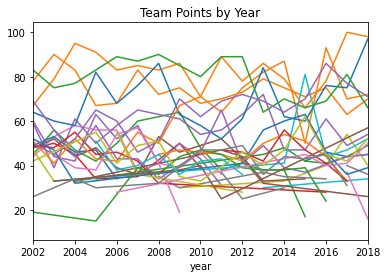

In [77]:
df.set_index('year').groupby('team_name').points.plot()
plt.title('Team Points by Year')
plt.show()

**Takeaways** At the top of the viz, you can see that there are a couple teams that have stayed at the top of the table, but as you get further towards the middle, the data becomes a lot more muddled

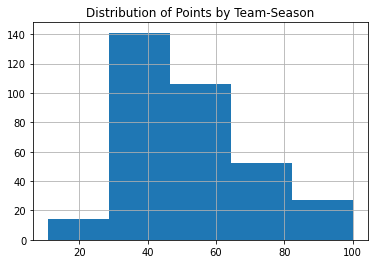

In [78]:
df.points.hist(bins=5)
plt.title("Distribution of Points by Team-Season")
plt.show()

**Takeaways** Looks like a poisson distribution.

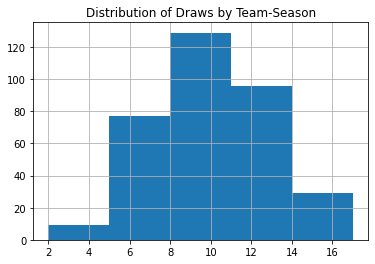

In [79]:
df.draws.hist(bins=5)
plt.title("Distribution of Draws by Team-Season")
plt.show()

**Takeaways** Normal distribution around 9-10 draws per season

In [80]:
df.draws.describe()

count    340.000000
mean       9.529412
std        2.819394
min        2.000000
25%        7.000000
50%        9.000000
75%       11.000000
max       17.000000
Name: draws, dtype: float64

Average number of draws per year is 9.5

### Exploring Draws a little more closely

Text(0.5, 1.0, 'Is There a Pattern for Draws by Table Place?')

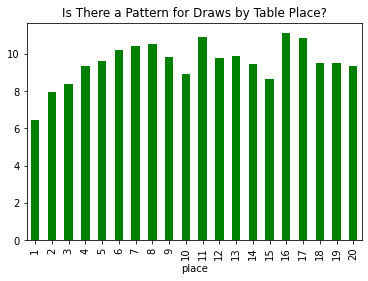

In [81]:
df.groupby('place').draws.mean().plot.bar(color='green')
plt.title('Is There a Pattern for Draws by Table Place?')

**Takeaways** Number of draws tend to be higher at the middle of the table

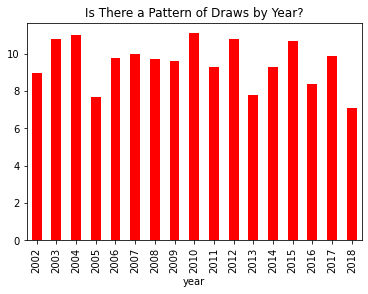

In [82]:
df.groupby('year').draws.mean().plot.bar(color='red')
plt.title('Is There a Pattern of Draws by Year?')
plt.show()

**Takeaways** Not really, there is a pretty significant difference between certain years, but no noticeable trends
**Furtherwork** Some hypothesis testing and statistical analysis

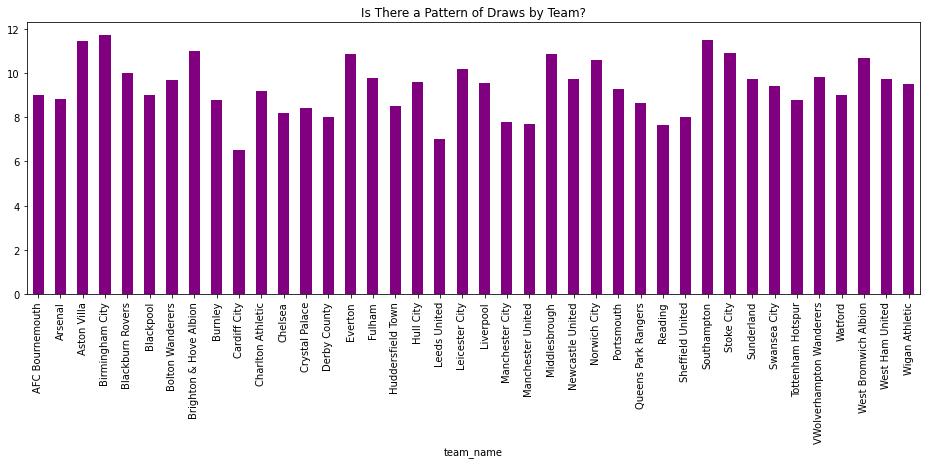

In [83]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.mean().plot.bar(color='purple')
plt.title('Is There a Pattern of Draws by Team?')
plt.show()

**Takeaways** Likely, but not immediately evident.

Text(0.5, 1.0, 'Because of Relegation, How Many Seasons Has Each Team Played?')

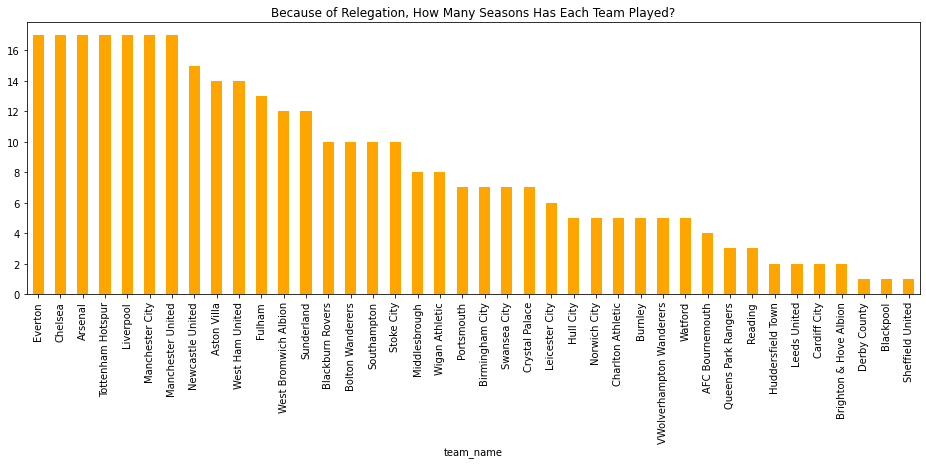

In [84]:
plt.figure(figsize=(16,5))
df.groupby('team_name').draws.count().sort_values(ascending=False).plot.bar(color='orange')
plt.title('Because of Relegation, How Many Seasons Has Each Team Played?')

### Just for fun , lets look at scatter plots of number of seasons and average number of points and draws!

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg No of Draws')

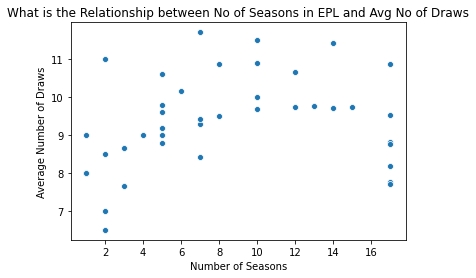

In [85]:
df_temp = df.groupby('team_name').draws.agg(['count', 'mean'])
sns.scatterplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Draws')
plt.title('What is the Relationship between No of Seasons in EPL and Avg No of Draws')

Text(0.5, 1.0, 'What is the Relationship between No of Seasons in EPL and Avg Points')

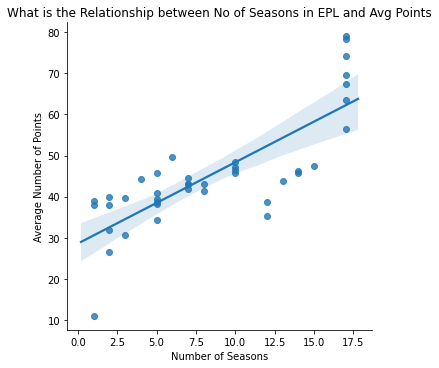

In [86]:
df_temp = df.groupby('team_name').points.agg(['count', 'mean'])
sns.lmplot(x='count', y='mean', data=df_temp)
plt.xlabel('Number of Seasons')
plt.ylabel('Average Number of Points')
plt.title('What is the Relationship between No of Seasons in EPL and Avg Points')

**Takeaways:** Seems to be a pretty clear linear relationship between number of seasons in the Premier League and the Average number of Points

Text(0.5, 1.0, 'What is the relationship between points and goal differential')

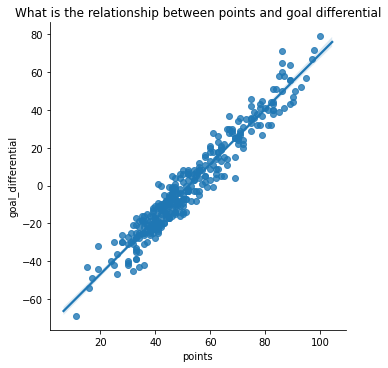

In [87]:
sns.lmplot(x='points', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and goal differential')

Text(0.5, 1.0, 'What is the relationship between points and place')

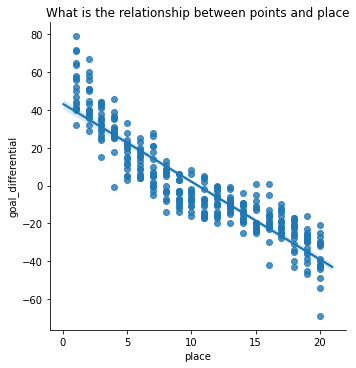

In [88]:
sns.lmplot(x='place', y = 'goal_differential', data = df)
plt.title('What is the relationship between points and place')

### Is it better to win or avoid a loss?

Text(0, 0.5, 'Absolute value of correlation')

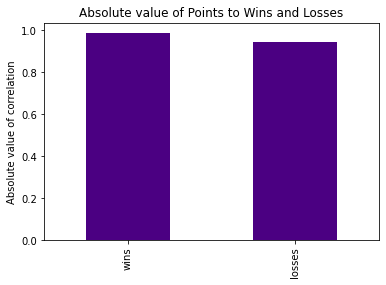

In [89]:
df[['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses")
plt.ylabel('Absolute value of correlation')

**Takeaways:** Although there is a high absolute correlation to both.  It appears that winning is more important than avoiding losses.

Text(0, 0.5, 'Absolute value of correlation')

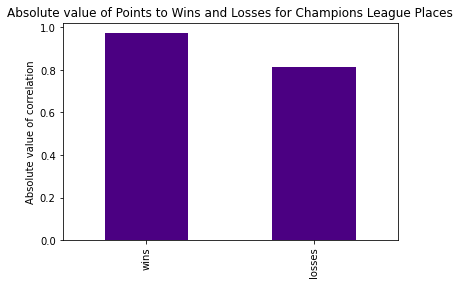

In [90]:
df[df.place <= 4][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

Text(0, 0.5, 'Absolute value of correlation')

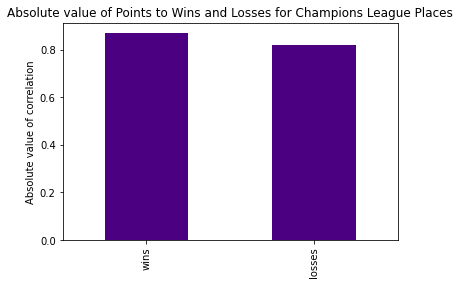

In [91]:
df[df.place >= 18][['wins', 'losses', 'points']].corr().points[0:2].abs().plot.bar(color='indigo')
plt.title("Absolute value of Points to Wins and Losses for Champions League Places")
plt.ylabel('Absolute value of correlation')

# Modeling

In [92]:
df_pred = df[(df.year - (df.next_year - 1)) == 0]

In [95]:
print(df_pred.shape)
df_pred.info()

(272, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 316
Data columns (total 14 columns):
index                 272 non-null int64
year                  272 non-null int64
team_name             272 non-null object
games_played          272 non-null int64
wins                  272 non-null int64
draws                 272 non-null int64
losses                272 non-null int64
goals_for             272 non-null int64
goals_against         272 non-null int64
goal_differential     272 non-null int64
points                272 non-null int64
place                 272 non-null int64
next_year             272 non-null float64
next_season_points    272 non-null float64
dtypes: float64(2), int64(11), object(1)
memory usage: 31.9+ KB


In [ ]:
X = df_pred.d

In [ ]:
predictions

In [97]:
X = df[['wins', 'draws', 'losses', 'goals_for', 'goals_against','goal_differential', 'points']]
y = df[['next_season_points']]